# Data Science Case Study
## Classification of 7 different activities of a roofbolter

_Author: Fred Bone_

---

**Domain Background**
A roofbolter is an underground mining machine that reinforces roofs of mine haulageways. It essentially drills holes in the roof and secures a bolt in each hole. The machine has two engines, a Diesel engine for traveling and a hydraulic engine for the drilling/anchoring.

**problem statement**
The main objective of this project will be to use classification models and find the best one out of the ones used, to classify the 7 different activities from the sensor data provided. 

**Datasets and Inputs**
The data set was provided by Talpasolutions GmbH. In data_case_study.csv we have about a week’s worth of second-based sensor data from an operating roofbolter. For this week the data has been labeled with the activity that the roofbolter is performing:
- Machine off, i.e. all engines are turned off
- Idle: Machine is on but not working
- Traveling: Machine is moving in the mine
- Hole Setup: Preparation for drilling/anchoring
- Drilling
- Anchoring: Putting a bolt in a drilled hole
- Transitional Delay: Other hydraulic activities

In [ ]:
# Import libraries

# To handle datasets
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For information of missing value occurrence and correlation matrix about the locations of missing values in columns
import missingno as msno

# To split the datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Feature engineering and -scaling
from feature_engine import missing_data_imputers as mdi
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, FunctionTransformer


# To build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from numpy import argmax

# To evaluate the models
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# To persist the model and the scaler
import joblib
import pickle

# To visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

# To ignore the warnings
import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

##  I - Data Analysis

In [4]:
# load dataset
data = pd.read_csv('data_case_study.csv')

# Rows and columns of the data
print(data.shape)

# Visualise the dataset
data.head(1000)

(149795, 20)


,Unnamed: 0,timestamp,engine_speed,hydraulic_drive_off,drill_boom_in_anchor_position,pvalve_drill_forward,hydraulic_pump,bolt,boom_lift,boom_lower,boom_forward,boom_backward,drill_boom_turn_left,drill_boom_turn_right,drill_boom_turn_forward,drill_boom_turn_backward,beam_right,beam_left,anchor,activity
0,0,1534192356,74.898806,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Idle
1,1,1534192357,75.139756,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Idle
2,2,1534192358,74.647495,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Idle
3,3,1534192359,106.015541,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Traveling
4,4,1534192360,95.702048,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Traveling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,1534193354,0.000000,0.0,0.000000,616.661991,NaN,0.0,0.0,0.0,0.0,2.614998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Machine Off
996,996,1534193355,0.000000,0.0,0.000000,616.661991,NaN,0.0,0.0,0.0,0.0,2.614998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Machine Off
997,997,1534193356,0.000000,0.0,0.000000,616.661991,NaN,0.0,0.0,0.0,0.0,2.614998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Machine Off
998,998,1534193357,0.000000,0.0,0.000000,616.661991,NaN,0.0,0.0,0.0,0.0,2.614998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Machine Off


The data contains 149795 rows (observations) and 20 columns (variables). The last column (activity) is the one that we will try to predict. The first column seems to have the index of each observation and thus won't be take into account for the analysis. We will analyse the dataset to identify:

1. Identify numerical / categorical variables
2. Missing values
3. Is the data set balanced or unbalanced?
4. Outliers
5. Potential variables that could be dropped by checking the correlation matrix

To check if the first column is simply an index column, we will calculate its first discrete difference (first_diff[i] = first_diff[i+1] - first_diff[i], i = 1, ...149795) and see if all values are equals to 1 and the length of this vector is equal to 149794.

In [5]:
first_diff = np.diff(data[data.columns[0]])
first_diff
np.all(first_diff==1) and len(first_diff) == 149794

True

In [6]:
# Delete the first column of the data
data = data.drop([data.columns[0]], axis=1)
# Checking the columns
data.columns

Index(['timestamp', 'engine_speed', 'hydraulic_drive_off',
       'drill_boom_in_anchor_position', 'pvalve_drill_forward',
       'hydraulic_pump', 'bolt', 'boom_lift', 'boom_lower', 'boom_forward',
       'boom_backward', 'drill_boom_turn_left', 'drill_boom_turn_right',
       'drill_boom_turn_forward', 'drill_boom_turn_backward', 'beam_right',
       'beam_left', 'anchor', 'activity'],
      dtype='object')

### 1. Identify numerical / categorical variables

In [58]:
# make list of numerical variables
num_vars = [var for var in data.columns if data[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_vars))
print(num_vars)

Number of numerical variables:  18
['engine_speed', 'hydraulic_drive_off', 'drill_boom_in_anchor_position', 'pvalve_drill_forward', 'hydraulic_pump', 'bolt', 'boom_lift', 'boom_lower', 'boom_forward', 'boom_backward', 'drill_boom_turn_left', 'drill_boom_turn_right', 'drill_boom_turn_forward', 'drill_boom_turn_backward', 'beam_right', 'beam_left', 'anchor', 'le_activity']


In [59]:
# Capture categorical variables in a list
cat_vars = [var for var in data.columns[-1:] if data[var].dtypes == 'O']

print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  1


In [63]:
list(data.columns[:-1])

['engine_speed',
 'hydraulic_drive_off',
 'drill_boom_in_anchor_position',
 'pvalve_drill_forward',
 'hydraulic_pump',
 'bolt',
 'boom_lift',
 'boom_lower',
 'boom_forward',
 'boom_backward',
 'drill_boom_turn_left',
 'drill_boom_turn_right',
 'drill_boom_turn_forward',
 'drill_boom_turn_backward',
 'beam_right',
 'beam_left',
 'anchor',
 'activity']

In [64]:
data.columns

Index(['engine_speed', 'hydraulic_drive_off', 'drill_boom_in_anchor_position',
       'pvalve_drill_forward', 'hydraulic_pump', 'bolt', 'boom_lift',
       'boom_lower', 'boom_forward', 'boom_backward', 'drill_boom_turn_left',
       'drill_boom_turn_right', 'drill_boom_turn_forward',
       'drill_boom_turn_backward', 'beam_right', 'beam_left', 'anchor',
       'activity', 'le_activity'],
      dtype='object')

### 2. Missing values

In [7]:
# List of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# Descending percentage of missing values
print("Number of variables with missing values: {0}".format(len(vars_with_na)))
print("Descending percentage of missing values:")
data[vars_with_na].isnull().mean().sort_values(ascending=False)

Number of variables with missing values: 14
Descending percentage of missing values:


hydraulic_pump              0.943583
pvalve_drill_forward        0.003305
anchor                      0.003164
beam_left                   0.003164
beam_right                  0.003164
drill_boom_turn_backward    0.003164
drill_boom_turn_forward     0.003164
drill_boom_turn_right       0.003164
drill_boom_turn_left        0.003164
boom_backward               0.003164
boom_forward                0.003164
boom_lower                  0.003164
boom_lift                   0.003164
bolt                        0.002977
dtype: float64

Almost 94% of the variable hydraulic_pump is missing. The percentage of missingness of the remainings variables is low and is almost the same. Does that mean that the observations of these variables are missing in the same rows? Let's check it with some diagnostic plots.

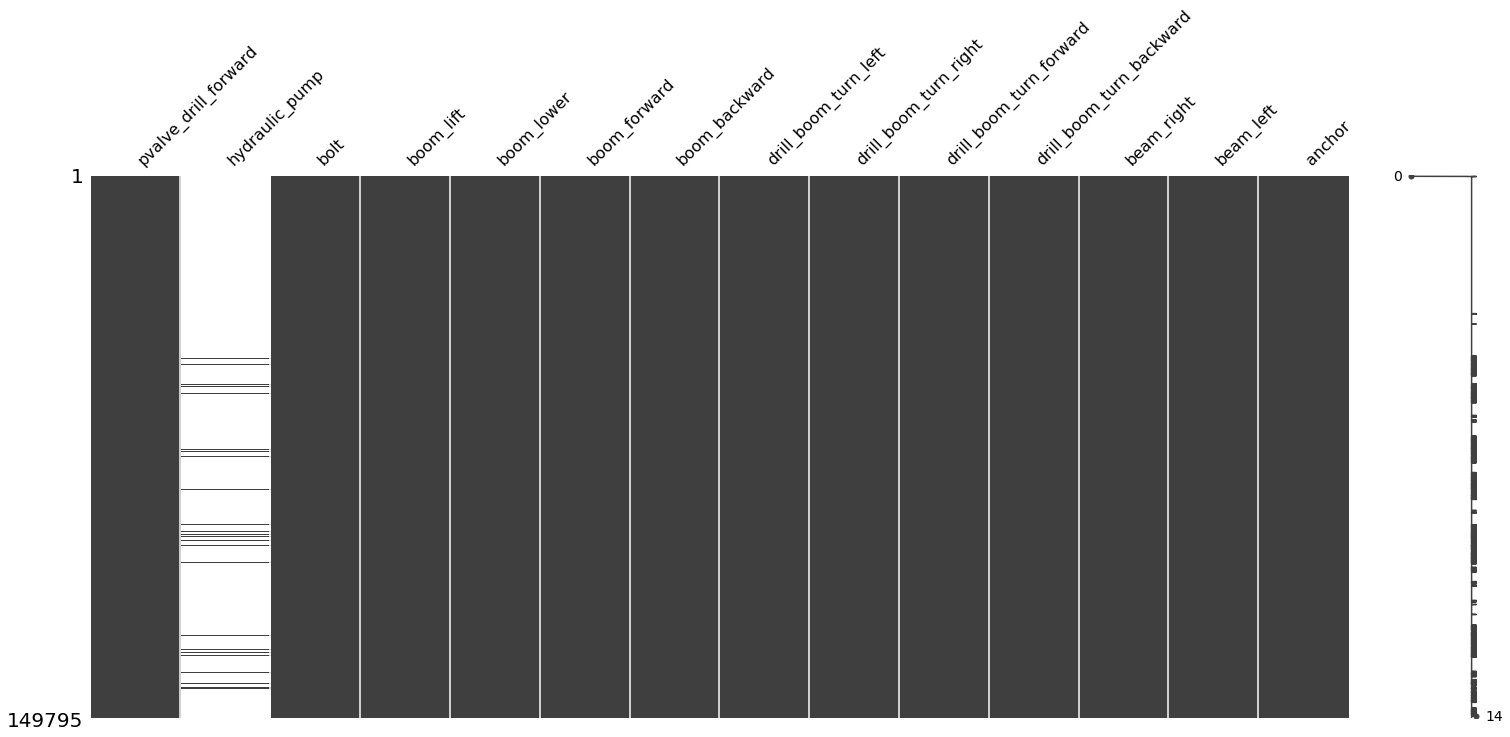

In [9]:
msno.matrix(data[vars_with_na])

At first glance, the pattern of missingness of these variables seems to be the same. Let's dive a little deeper by visualizing the correlation matrix about the locations of missing values in these columns.

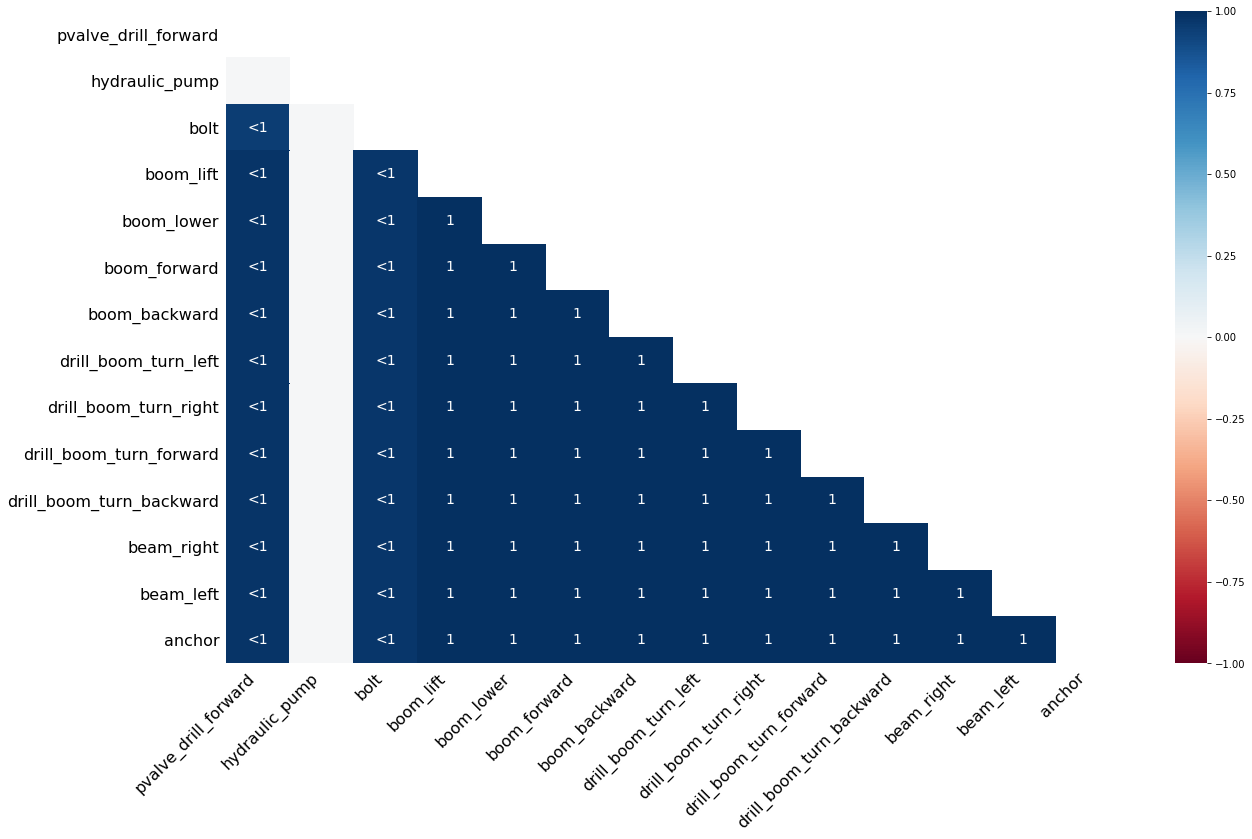

In [10]:
msno.heatmap(data[vars_with_na])

In [55]:
num_vars_miss = list(set(num_vars) & set(vars_with_na))
print(num_vars_miss)
cat_vars_miss = [e for i,e in enumerate(vars_with_na) if e not in num_vars_miss]
print(cat_vars_miss)

['bolt', 'drill_boom_turn_right', 'drill_boom_turn_forward', 'drill_boom_turn_backward', 'boom_forward', 'beam_left', 'boom_backward', 'beam_right', 'anchor', 'boom_lower', 'drill_boom_turn_left', 'pvalve_drill_forward', 'hydraulic_pump', 'boom_lift']
[]


All the variables having missing values seem to be numerical variables. Let's check it.

In [ ]:
sorted(num_vars_miss) == sorted(vars_with_na) 

So they are all numerical variables. Thus we will only have to find a strategy to impute numerical variables.

As we can see from the above correlation plot, except for the variable hydraulic_pump, the correlation about the locations of missing values in these variables is 1 or roughly equals to 1 meaning that they are missing in the same rows. Thus on the one hand because of their lower percentage of missingness and on the other hand because of the fact that there's a higher correlation in the way their observations are missing, except for the variable hydraulic_pump, we won't add a missing indicator column. 
Our strategy to tackle the missing values will be the following:
    1. add a new binary column (hydraulic_pump_na) to the data that indicates where observations are missing in the column    hydraulic_pump
    2. Find the best method (mean vs median) to impute the missing values by evaluating the performance of a baseline model using both values.
    3.Replace the missing values in each column (hydraulic_pump included) with the corresponding best parameter found in the second step.
    
Remark: We will add the column that flags the missing values of hydraulic_pump as we assume that due to its high percentage of missingness (94%), it is not due to an accident (could be almost the same for any other data dump of the sensor) and thus could have a predictive value. Otherwise, we would have used only the two last steps.

### 3. Is the data set balanced or unbalanced?

In [13]:
data['activity'].value_counts() / len(data['activity'])

Machine Off           0.374131
Transitional Delay    0.162669
Drilling              0.145459
Traveling             0.141794
Idle                  0.084829
Hole Setup            0.070576
Anchoring             0.020541
Name: activity, dtype: float64

<Figure size 576x432 with 0 Axes>

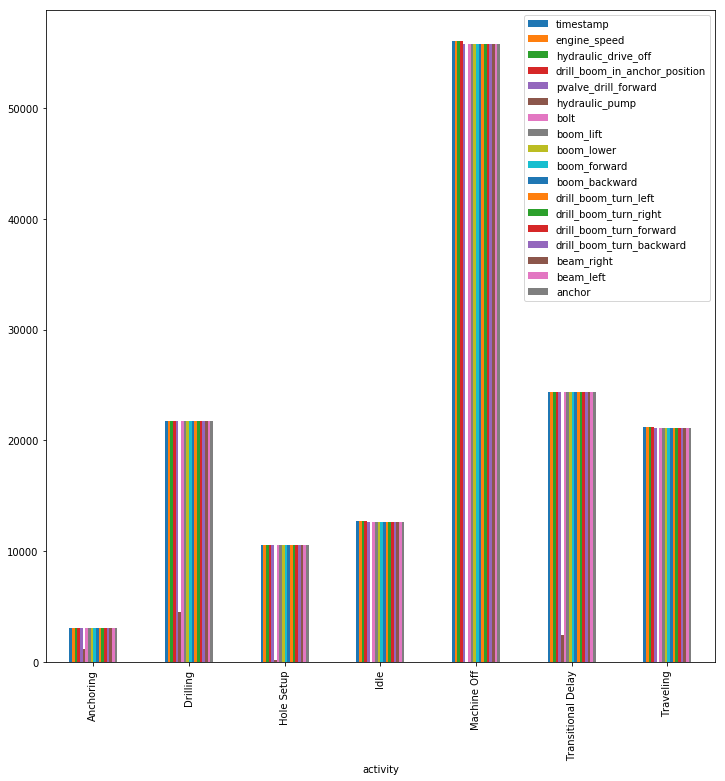

In [14]:
fig = plt.figure(figsize=(8,6))
data.groupby('activity').count().plot.bar(ylim=0, figsize=(12,12))
plt.show()

The data set is unbalanced with the class Machine Off having the highest proportion of records. Within each class, the repartition of all features seems to be the same. 
As the least populated class (Anchoring) has almost 3000 observations, we won't do any resampling technique (oversampling, undersampling, SMOVE, etc) and will instead use metrics that are appropriate to evaluate models on unbalanced data sets (Weighted F1 score, Precision, Recall).
Additionally, while splitting the data in the train/test set, we will make sure that the train set reflects the same proportion of data we had in each class (so-called stratified sample).

In [41]:
data[data['boom_lift'].isnull()]['activity'].value_counts()

Machine Off           317
Traveling             100
Idle                   29
Transitional Delay     28
Name: activity, dtype: int64

In [42]:
data[data['pvalve_drill_forward'].isnull()]['activity'].value_counts()

Machine Off           317
Traveling             100
Transitional Delay     36
Idle                   29
Hole Setup             13
Name: activity, dtype: int64

In [43]:
data[data['bolt'].isnull()]['activity'].value_counts()

Machine Off    317
Traveling      100
Idle            29
Name: activity, dtype: int64

In [44]:
data[data['hydraulic_pump'].isnull()]['activity'].value_counts()

Machine Off           56036
Transitional Delay    21925
Traveling             21198
Drilling              17265
Idle                  12697
Hole Setup            10351
Anchoring              1872
Name: activity, dtype: int64

In [19]:
df = data.copy()
df= df[df['hydraulic_pump'].notnull()][['hydraulic_pump', 'activity']]
df.groupby('activity')['hydraulic_pump'].mean()


activity
Anchoring                0.000000
Drilling              7513.756101
Hole Setup            6625.744457
Idle                     0.000000
Machine Off              0.000000
Transitional Delay    2165.053566
Traveling                0.000000
Name: hydraulic_pump, dtype: float64

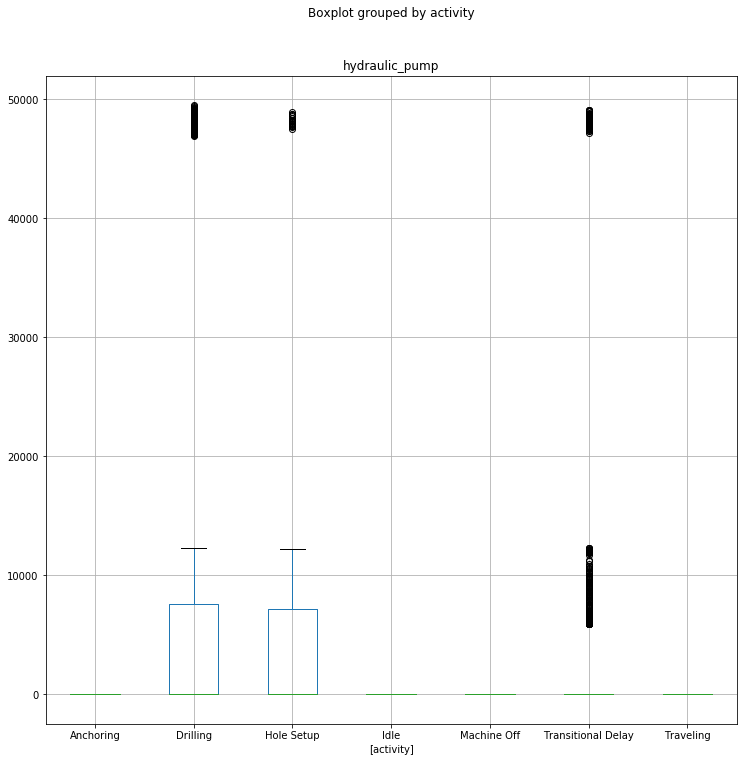

In [15]:
data[['hydraulic_pump', 'activity']].boxplot(by='activity', figsize=(12,12))

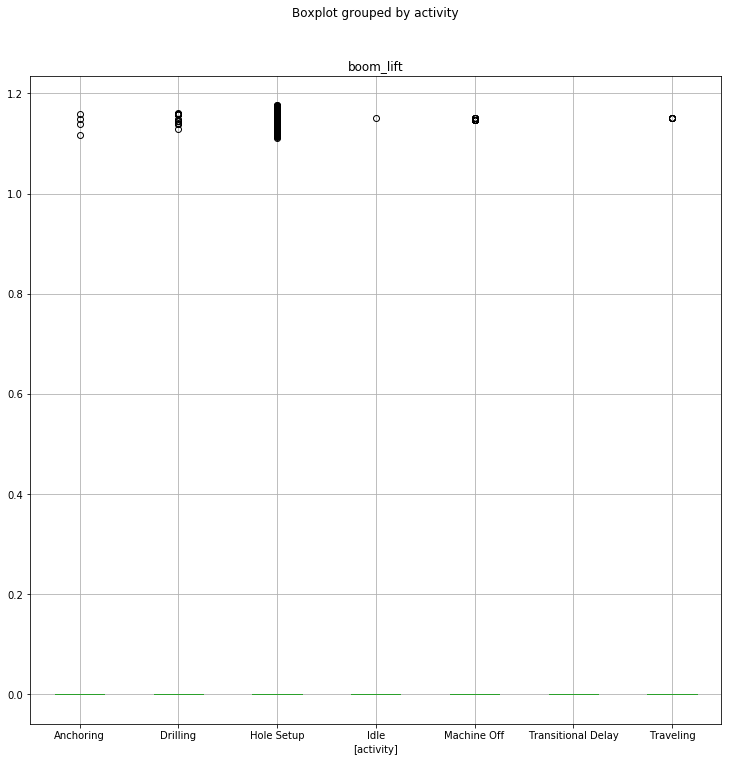

In [16]:
data[['boom_lift', 'activity']].boxplot(by='activity', figsize=(12,12))

In [17]:
# make list of numerical variables
num_vars = [var for var in data.columns if data[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_vars))

Number of numerical variables:  18


In [18]:
num_vars_miss = list(set(num_vars) & set(vars_with_na))
print(num_vars_miss)
cat_vars_miss = [e for i,e in enumerate(vars_with_na) if e not in num_vars_miss]
print(cat_vars_miss)

['bolt', 'drill_boom_turn_right', 'drill_boom_turn_forward', 'drill_boom_turn_backward', 'boom_forward', 'beam_left', 'boom_backward', 'beam_right', 'anchor', 'boom_lower', 'drill_boom_turn_left', 'pvalve_drill_forward', 'hydraulic_pump', 'boom_lift']
[]


In [19]:
sorted(num_vars_miss) == sorted(vars_with_na) 

True

In [ ]:
def analyse_na_value(data, var):

    data = data.copy()

    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    data[var] = np.where(data[var].isnull(), 1, 0)

    # let's compare the median SalePrice in the observations where data is missing
    # vs the observations where a value is available

    data.groupby(var)['SalePrice'].median().plot.bar()

    plt.title(var)
    plt.show()


# let's run the function on each variable with missing data
for var in vars_with_na:
    analyse_na_value(data, var)

In [20]:
# Capture categorical variables in a list
cat_vars = [var for var in data.columns[:-1] if data[var].dtypes == 'O']

print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  0


The only categorical variable is the variable to be predicted.

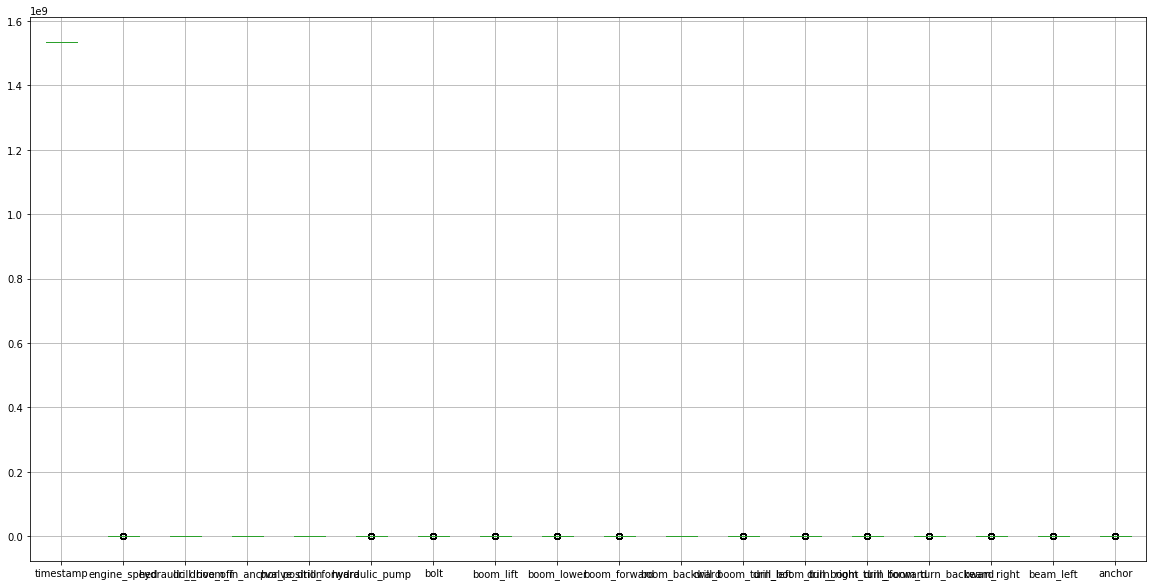

In [21]:
# outliers

data[num_vars].boxplot(figsize=(20,10))

### 5. Potential variables that could be dropped by checking the correlation matrix

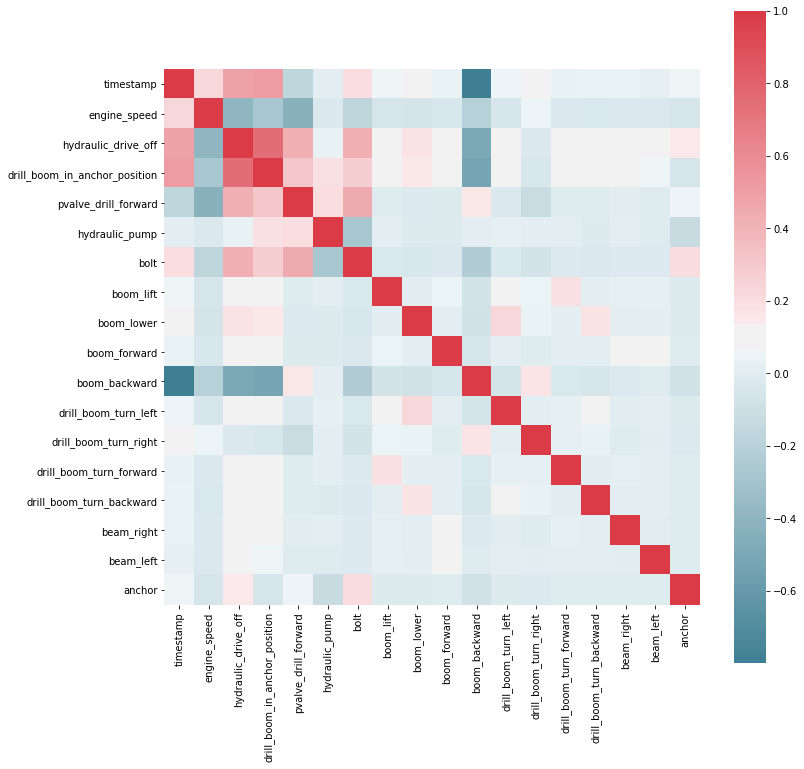

In [22]:
f, ax = plt.subplots(figsize=(12, 12))
corr = data[num_vars].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [23]:
data = data.drop(['timestamp'], axis=1)
num_vars = [e for i,e in enumerate(num_vars) if e != 'timestamp']
num_vars

['engine_speed',
 'hydraulic_drive_off',
 'drill_boom_in_anchor_position',
 'pvalve_drill_forward',
 'hydraulic_pump',
 'bolt',
 'boom_lift',
 'boom_lower',
 'boom_forward',
 'boom_backward',
 'drill_boom_turn_left',
 'drill_boom_turn_right',
 'drill_boom_turn_forward',
 'drill_boom_turn_backward',
 'beam_right',
 'beam_left',
 'anchor']

In [24]:
# Label encode the target variable
le = LabelEncoder()
data['le_activity'] = le.fit_transform(data['activity'])

# Persist label encoder
np.save('classes.npy', le.classes_)
# le = LabelEncoder()
# le.classes_ = numpy.load('classes.npy')

list(le.classes_)

['Anchoring',
 'Drilling',
 'Hole Setup',
 'Idle',
 'Machine Off',
 'Transitional Delay',
 'Traveling']

In [29]:
le.inverse_transform([2, 2, 1])

array(['Hole Setup', 'Hole Setup', 'Drilling'], dtype=object)

In [25]:
data.columns

Index(['engine_speed', 'hydraulic_drive_off', 'drill_boom_in_anchor_position',
       'pvalve_drill_forward', 'hydraulic_pump', 'bolt', 'boom_lift',
       'boom_lower', 'boom_forward', 'boom_backward', 'drill_boom_turn_left',
       'drill_boom_turn_right', 'drill_boom_turn_forward',
       'drill_boom_turn_backward', 'beam_right', 'beam_left', 'anchor',
       'activity', 'le_activity'],
      dtype='object')

In [26]:
len(data.columns)

19

In [27]:
# Separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['activity', 'le_activity'], axis=1),  # just the features
    data['le_activity'],  # the target
    test_size=0.3,  # the percentage of observations in the test set
    random_state=101, # for reproducibility
   stratify=data['le_activity'])  # To create datasets featuring the same percentage of classes as the original one

X_train.shape, X_test.shape

((104856, 17), (44939, 17))

Checking if the training set is stratified

In [28]:
print("Percentage of classes in the original data:")
print(data['activity'].value_counts() / len(data['activity']))
print("")
print("Percentage of classes in the training set:")
print(pd.DataFrame(y_train).value_counts() / len(y_train))

Percentage of classes in the original data:
Machine Off           0.374131
Transitional Delay    0.162669
Drilling              0.145459
Traveling             0.141794
Idle                  0.084829
Hole Setup            0.070576
Anchoring             0.020541
Name: activity, dtype: float64

Percentage of classes in the training set:
le_activity
4              0.374132
5              0.162671
1              0.145457
6              0.141794
3              0.084831
2              0.070573
0              0.020542
dtype: float64


In [29]:
# Preprocessing pipeline for the numerical variables

numeric_transformer = Pipeline(steps=[
    ('missing_ind', mdi.AddMissingIndicator(
     how='missing_only', variables=['hydraulic_pump'])),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_vars)],
                    remainder='passthrough', # To keep the added missing indicator variable of 'hydraulic_pump' ('hydraulic_pump_na')
                    n_jobs=-1)

# To initialise the pipeline I passed any argument to the transformers.
# Those will be changed during the gridsearch below.


In [30]:
numeric_transformer.transform

<bound method Pipeline._transform of Pipeline(steps=[('missing_ind',
                 AddMissingIndicator(variables=['hydraulic_pump'])),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())])>

In [31]:
numeric_transformer.named_steps['missing_ind']

AddMissingIndicator(variables=['hydraulic_pump'])

In [32]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(C=1, random_state=101, solver='lbfgs',
                          multi_class='multinomial', max_iter = 100))])

In [33]:
# Grid with all the parameters that we would like to test

param_grid = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median']
}

grid_search = GridSearchCV(clf, param_grid, cv=3, iid=False, n_jobs=-1, scoring='f1_weighted')

# cv=3 is the cross-validation
# no_jobs =-1 indicates to use all available cpus
# scoring='f1_weighted' indicates to evaluate using the weighted F1 score (to account for label imbalance)
# iid=False the loss minimized is the total loss per sample, and not the mean loss across the folds

In [34]:
# Train over all the possible combinations of the parameters above
grid_search.fit(X_train, y_train)

# Print the best score over the train set
print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_train, y_train)))

best logistic regression from grid search: 0.995


In [35]:
# Best estimator parameters 
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('missing_ind',
                                                                   AddMissingIndicator(variables=['hydraulic_pump'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['engine_speed',
                                                   'hydraulic_drive_off',
                                                   'drill_boom_in_anchor_position',
                                                   'pvalve_drill_forward',
      

In [36]:
# Best fit parameters or imputation strategy 
grid_search.best_params_

{'preprocessor__numerical__imputer__strategy': 'mean'}

In [37]:
# Combinations evaluated during the gridsearch
grid_search.cv_results_['params']

[{'preprocessor__numerical__imputer__strategy': 'mean'},
 {'preprocessor__numerical__imputer__strategy': 'median'}]

In [38]:
# Performance over the test set
print(("Best logistic regression from grid search on test data: %.3f"
       % grid_search.score(X_test, y_test)))

Best logistic regression from grid search on test data: 0.994


In [39]:
# Preprocessing pipeline for the numerical variables

numeric_transformer = Pipeline(steps=[
    ('missing_ind', mdi.AddMissingIndicator(
     how='missing_only', variables=['hydraulic_pump'])),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_vars)],
                    remainder='passthrough', 
                    n_jobs=-1)


In [ ]:
# Preprocessing pipeline for the numerical variables

variables_to_drop = ['Unnamed: 0', 'timestamp']
def Drop_Unecessary_Columns(data, variables_to_drop=variables_to_drop):
    data = data.copy()
    data = data[data.columns[~data.columns.isin(variables_to_drop)]]
    return data


numeric_transformer = Pipeline(steps=[
    ('feature_selection',  FunctionTransformer(Drop_Unecessary_Columns)),
    ('missing_ind', mdi.AddMissingIndicator(
     how='missing_only', variables=['hydraulic_pump'])),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_vars)],
                    remainder='passthrough', 
                    n_jobs=-1)


In [48]:
clf_lr = LogisticRegression(C=1, random_state=101, solver='lbfgs',
                          multi_class='multinomial', max_iter = 100)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.fit_transform(X_test)
clf_lr.fit(X_train_prep, y_train)

LogisticRegression(C=1, multi_class='multinomial', random_state=101)

In [ ]:
# Funtion to evaluate the model
def evaluate(model, X_test, y_test, tuned=None, model_type=None, oe=None):
    labels = [0, 1, 2, 3, 4, 5, 6]
    if model_type:
        y_pred = model.predict(X_test)
        # One hot encode the prediction
        y_pred = oe.fit_transform(array(y_pred).reshape(-1,1) ).toarray()
        # Decode the prediction
        y_pred = oe.inverse_transform(y_pred)
        # Flattening the list of NumPy arrays
        y_pred = np.concatenate(y_pred).ravel()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        print('{} Performance:'.format(model_type))
    else:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if tuned:
            print('{} {} Performance:'.format(tuned, type(model).__name__))
        else:
            print('{} Performance:'.format(type(model).__name__))     
    print(classification_report(y_test, y_pred))
    print('Accuracy:{}'.format(accuracy))
    print('Confusion Matrix:')
    cm = confusion_matrix(y_test, y_pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


LogisticRegression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       923
           1       1.00      1.00      1.00      6537
           2       1.00      1.00      1.00      3172
           3       0.95      0.99      0.97      3812
           4       1.00      1.00      1.00     16813
           5       1.00      1.00      1.00      7310
           6       1.00      0.97      0.98      6372

    accuracy                           0.99     44939
   macro avg       0.99      0.99      0.99     44939
weighted avg       0.99      0.99      0.99     44939

Accuracy:0.9942143794922005
Confusion Matrix:
[[  923     0     0     0     0     0     0]
 [    0  6527     5     0     0     5     0]
 [    0     1  3170     0     0     0     1]
 [    0     1     0  3761    48     0     2]
 [    0     0     0     0 16813     0     0]
 [    0     6     0     0     0  7304     0]
 [    0     0     0   191     0     0  6181]]


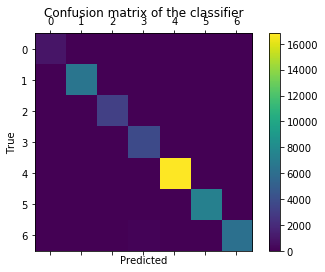

In [49]:
# Evaluation
evaluate(clf_lr, X_test_prep, y_test)

In [114]:
# we persist the model for future use
joblib.dump(grid_search.best_estimator_, 'logistic_regression.pkl')

['logistic_regression.pkl']

In [55]:
a = preprocessor.fit_transform(X_train)
a

array([[0.        , 0.97052566, 0.9782607 , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.97736173, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.34298218, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.34187608, 0.        , 0.96546649, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [260]:
pd.DataFrame(X_train).head(15)

,engine_speed,hydraulic_drive_off,drill_boom_in_anchor_position,pvalve_drill_forward,hydraulic_pump,bolt,boom_lift,boom_lower,boom_forward,boom_backward,drill_boom_turn_left,drill_boom_turn_right,drill_boom_turn_forward,drill_boom_turn_backward,beam_right,beam_left,anchor
97046,0.000000,0.083955,0.478897,1312.844774,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
65580,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
80751,216.917949,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
16027,0.000000,0.000000,0.000000,616.661991,NaN,0.000000,0.0,0.000000,0.000000,2.614998,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
67264,0.000000,0.082080,0.473758,96.001013,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4082,0.000000,0.000000,0.000000,616.661991,NaN,0.000000,0.0,0.000000,0.000000,2.614998,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
124871,0.000000,0.084111,0.476899,758.135670,0.0,0.000000,0.0,0.145949,0.000000,0.000000,0.0,0.000000,0.0,0.404162,0.0,0.0,0.0
74493,0.000000,0.084786,0.472918,1304.514304,NaN,1.384568,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
146610,75.203048,0.000000,0.000000,391.745418,NaN,0.000000,0.0,0.000000,0.000000,2.604760,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
29222,0.000000,0.000000,0.000000,616.661991,NaN,0.000000,0.0,0.000000,0.000000,2.614998,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [56]:
b=pd.DataFrame(a)
b.columns = ['hydraulic_drive_off',
 'drill_boom_in_anchor_position',
 'pvalve_drill_forward',
 'hydraulic_pump',
 'bolt',
 'boom_lift',
 'boom_lower',
 'boom_forward',
 'boom_backward',
 'drill_boom_turn_left',
 'drill_boom_turn_right',
 'drill_boom_turn_forward',
 'drill_boom_turn_backward',
 'beam_right',
 'beam_left',
 'anchor', 'hydraulic_pump_na', 'engine_speed']
b.head(15)

,hydraulic_drive_off,drill_boom_in_anchor_position,pvalve_drill_forward,hydraulic_pump,bolt,boom_lift,boom_lower,boom_forward,boom_backward,drill_boom_turn_left,drill_boom_turn_right,drill_boom_turn_forward,drill_boom_turn_backward,beam_right,beam_left,anchor,hydraulic_pump_na,engine_speed
0,0.000000,0.970526,0.978261,0.975048,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
2,0.977362,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
3,0.000000,0.000000,0.000000,0.457994,0.0,0.000000,0.0,0.000000,0.000000,0.969318,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
4,0.000000,0.948857,0.967762,0.071300,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
5,0.000000,0.000000,0.000000,0.457994,0.0,0.000000,0.0,0.000000,0.000000,0.969318,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
6,0.000000,0.972329,0.974179,0.563066,0.0,0.000000,0.0,0.987153,0.000000,0.000000,0.0,0.000000,0.0,0.972431,0.0,0.0,0.0,0.0
7,0.000000,0.980133,0.966048,0.968861,0.0,0.971566,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
8,0.338840,0.000000,0.000000,0.290949,0.0,0.000000,0.0,0.000000,0.000000,0.965523,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
9,0.000000,0.000000,0.000000,0.457994,0.0,0.000000,0.0,0.000000,0.000000,0.969318,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0


In [57]:
b['hydraulic_pump_na'].value_counts()

0.000000    103413
0.964446        51
0.966550        25
0.981850        25
0.971873        24
             ...  
0.963540         1
0.967503         1
0.980584         1
0.953335         1
0.972339         1
Name: hydraulic_pump_na, Length: 611, dtype: int64

In [230]:
pd.DataFrame(X_train)['hydraulic_pump'].isnull().sum() + sum(pd.DataFrame(X_train)['hydraulic_pump'] == 0.0)
#pd.DataFrame(X_train)['hydraulic_pump'].notnull().sum()

103489

In [211]:
sum(pd.DataFrame(X_train)['hydraulic_pump'] == 0)

4590

In [148]:
b['hydraulic_pump'].value_counts()

0.000000        103489
7786.670158          1
8066.662822          1
47792.993080         1
48512.302964         1
                 ...  
6440.730659          1
8119.674694          1
2186.362554          1
48260.214248         1
7599.648111          1
Name: hydraulic_pump, Length: 1368, dtype: int64

In [71]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [74]:
get_column_names_from_ColumnTransformer(preprocessor)

[]

In [70]:
preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('missing_ind',
                                                  AddMissingIndicator(variables=['hydraulic_pump'])),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['engine_speed', 'hydraulic_drive_off',
                                  'drill_boom_in_anchor_position',
                                  'pvalve_drill_forward', 'hydraulic_pump',
                                  'bolt', 'boom_lift', 'boom_lower',
                                  'boom_forward', 'boom_backward',
                                  'drill_boom_turn_left',
                                  'drill_boom_turn_right',
                                  'drill_boom_turn_forward',
                                  'drill_boom

In [58]:
len(num_vars)

17

In [131]:
len(a[:-1])

104855

In [59]:
grid_search.score(X_test, y_test)

0.9942313714843211

In [60]:
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred
print( np.unique(y_pred))
pd.DataFrame(y_pred).value_counts()

[0 1 2 3 4 5 6]


4    16861
5     7309
1     6535
6     6184
3     3952
2     3175
0      923
dtype: int64

In [ ]:
X_train = preprocessor.fit_transform(X_train)

## Random Forest

In [51]:
# Create the parameter grid 
param_grid_rf = {
    'bootstrap': [True],
    'max_depth': [80, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [500, 1000, 1500, 2000],
    'criterion': ['entropy'],
    'random_state': [101] # for reproductivity
}
# Create a based model
clf_rf = RandomForestClassifier(criterion = 'entropy', random_state=101)
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = clf_rf, param_grid = param_grid_rf, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [52]:
# Fit the grid search to the data
grid_search_rf.fit(X_train_prep, y_train)
grid_search_rf.best_params_


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 102.6min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 131.9min finished


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 1500,
 'random_state': 101}

In [76]:
col_names = ['hydraulic_drive_off',
 'drill_boom_in_anchor_position',
 'pvalve_drill_forward',
 'hydraulic_pump',
 'bolt',
 'boom_lift',
 'boom_lower',
 'boom_forward',
 'boom_backward',
 'drill_boom_turn_left',
 'drill_boom_turn_right',
 'drill_boom_turn_forward',
 'drill_boom_turn_backward',
 'beam_right',
 'beam_left',
 'anchor', 'hydraulic_pump_na', 'engine_speed']

No handles with labels found to put in legend.


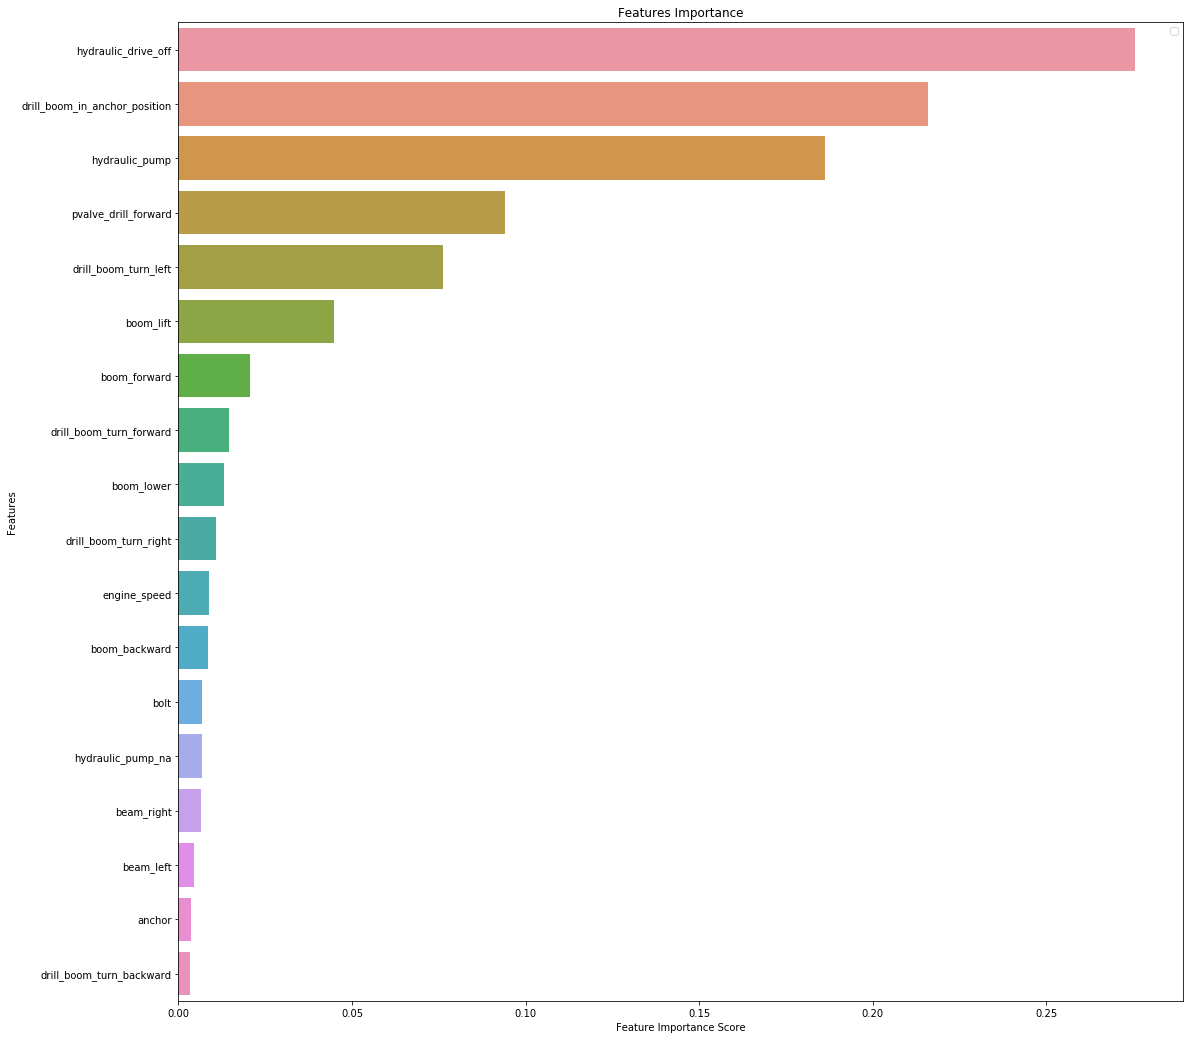

In [77]:
X_train_prep = pd.DataFrame(X_train_prep)
X_train_prep.columns = col_names
best_grid_rf = grid_search_rf.best_estimator_
feature_imp = pd.Series(best_grid_rf.feature_importances_, index=X_train_prep.columns).sort_values(ascending=False)
fig = plt.figure(figsize=(18, 18))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Features Importance")
plt.legend()
plt.show()


Tuned RandomForestClassifier Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       923
           1       1.00      1.00      1.00      6537
           2       1.00      1.00      1.00      3172
           3       1.00      1.00      1.00      3812
           4       1.00      1.00      1.00     16813
           5       1.00      1.00      1.00      7310
           6       1.00      1.00      1.00      6372

    accuracy                           1.00     44939
   macro avg       1.00      1.00      1.00     44939
weighted avg       1.00      1.00      1.00     44939

Accuracy:0.9994436903357885
Confusion Matrix:
[[  923     0     0     0     0     0     0]
 [    0  6536     0     0     0     1     0]
 [    0     0  3168     0     0     4     0]
 [    0     0     0  3806     0     0     6]
 [    0     0     0     0 16813     0     0]
 [    0     2     0     0     0  7308     0]
 [    0     0     0    12     0     0  6360]]

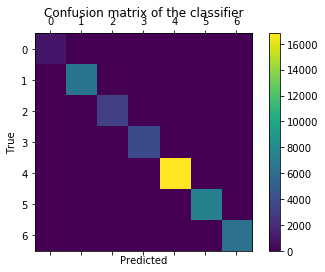

In [81]:
# Predicting the Test set results
y_pred_rf = best_grid_rf.predict(X_test_prep)
# Evaluation
evaluate(best_grid_rf, X_test_prep, y_test, tuned='Tuned')

In [82]:
# We persist the model for future use
joblib.dump(best_grid_rf, 'Random_Forest.pkl')

['Random_Forest.pkl']

## Neural Network

In [87]:
# One hot encode y_train
oe = OneHotEncoder(categories='auto')
oe_y_train = oe.fit_transform(np.array(y_train).reshape(-1,1) ).toarray()

# define baseline model
def base_model_nn(neurons_1=50, neurons_2=10, optimizer='adam',epochs=10, batch_size=10):
    # create model
    model = Sequential()
    # First hidden Layer
    model.add(Dense(neurons_1, input_dim=18, activation='relu'))
    # Second hidden Layer
    model.add(Dense(neurons_2, input_dim=18, activation='relu'))
    # Output Layer
    model.add(Dense(7, activation='softmax'))
# Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# Persist Onehot encoder
with open('oe_encoder.pickle', 'wb') as f:
    pickle.dump(oe, f)

In [88]:
# Create the parameter grid 
param_grid_nn = {
    'batch_size': [10, 60],
    'epochs': [10, 75],
    'optimizer': ['Adam', 'Adamax'],
    'neurons_1': [100, 250],
    'neurons_2': [50, 75]
}
# Create a based model
Classifier_base_model_nn = KerasClassifier(build_fn=base_model_nn, epochs=10, batch_size=5, verbose=1)

In [ ]:
# Instantiate the grid search model
grid_search_nn = GridSearchCV(estimator=Classifier_base_model_nn, param_grid=param_grid_nn, 
                          cv=3, n_jobs=-1, verbose=1)
grid_result_nn = grid_search_nn.fit(X_train_prep, oe_y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
# summarize results
print("Best accuray: {} using {}".format(grid_result_nn.best_score_, grid_result_nn.best_params_))
means = grid_result_nn.cv_results_['mean_test_score']
stds = grid_result_nn.cv_results_['std_test_score']
params = grid_result_nn.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Prediction
pred_tuned_model_nn = grid_result_nn.best_estimator_.predict(X_test_pred)
# One hot encode the prediction
pred_tuned_model_nn = oe.fit_transform(np.array(pred_tuned_model_nn).reshape(-1,1) ).toarray()
# Decode the prediction
pred_tuned_model_nn = oe.inverse_transform(pred_tuned_model_nn)
pred_tuned_model_nn = np.concatenate(pred_tuned_model_nn).ravel()

# Evaluation
evaluate(grid_result_nn.best_estimator_, X_test_pred, y_test, model_type='Tuned Neural Network', oe=oe)

In [ ]:
# We persist the model for future use
joblib.dump(grid_result_nn.best_estimator_, 'Neural_Network.pkl')

In [ ]:
grid_result_nn.best_estimator_.save("Neural_Network.h5")